# Lab 3: Asking a Statistical Question

## William Olsen, partners with Jennifer Vo

Within this report we will be focusing on how to ask a statistical question.  Asking and answering a statistical question is generally requires the following three steps:

1) Writing down in words _precisely_ what question we are trying to ask.
2) Translating the precise english into a mathematical expression.  Often containing the PDF of the background - determining of which can be considered a substep of this step.  Then evaluating the integral.
3) Converting the probability from the previous step into a sigma.

In this lab we will presume that we know the background distribution and will focus on asking the statistical question and getting the correct results in a clear manor.

In [1]:
# general imports
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats

# plotting setup
plt.rcParams["figure.figsize"] = (20,15)

## Problem 1

Let's presume that we are performing an experiment which requires precise temperature control to work reliably.  Specifically, we would like our temperature to be 12 Kelvin.  Our data shows that the temperature stays around a mean value of 12 Kelvin but has a standard deviation of 0.4 degrees which is the result of the thermal control systems.

At some points our system misbehaves and we see situations where the temperature is not near 12 K, additionally the thermometry has various glitches which results in very high or low readings that do not correspond to the true temperature.  While sometimes the outliner values are true readings they generally are not so we would like to look at how we can eliminate these outliers.

Let's begin by simulating some data for our hypothetical situation.  Lets generate some good data from a Gaussian distribution and then add some outlier readings:

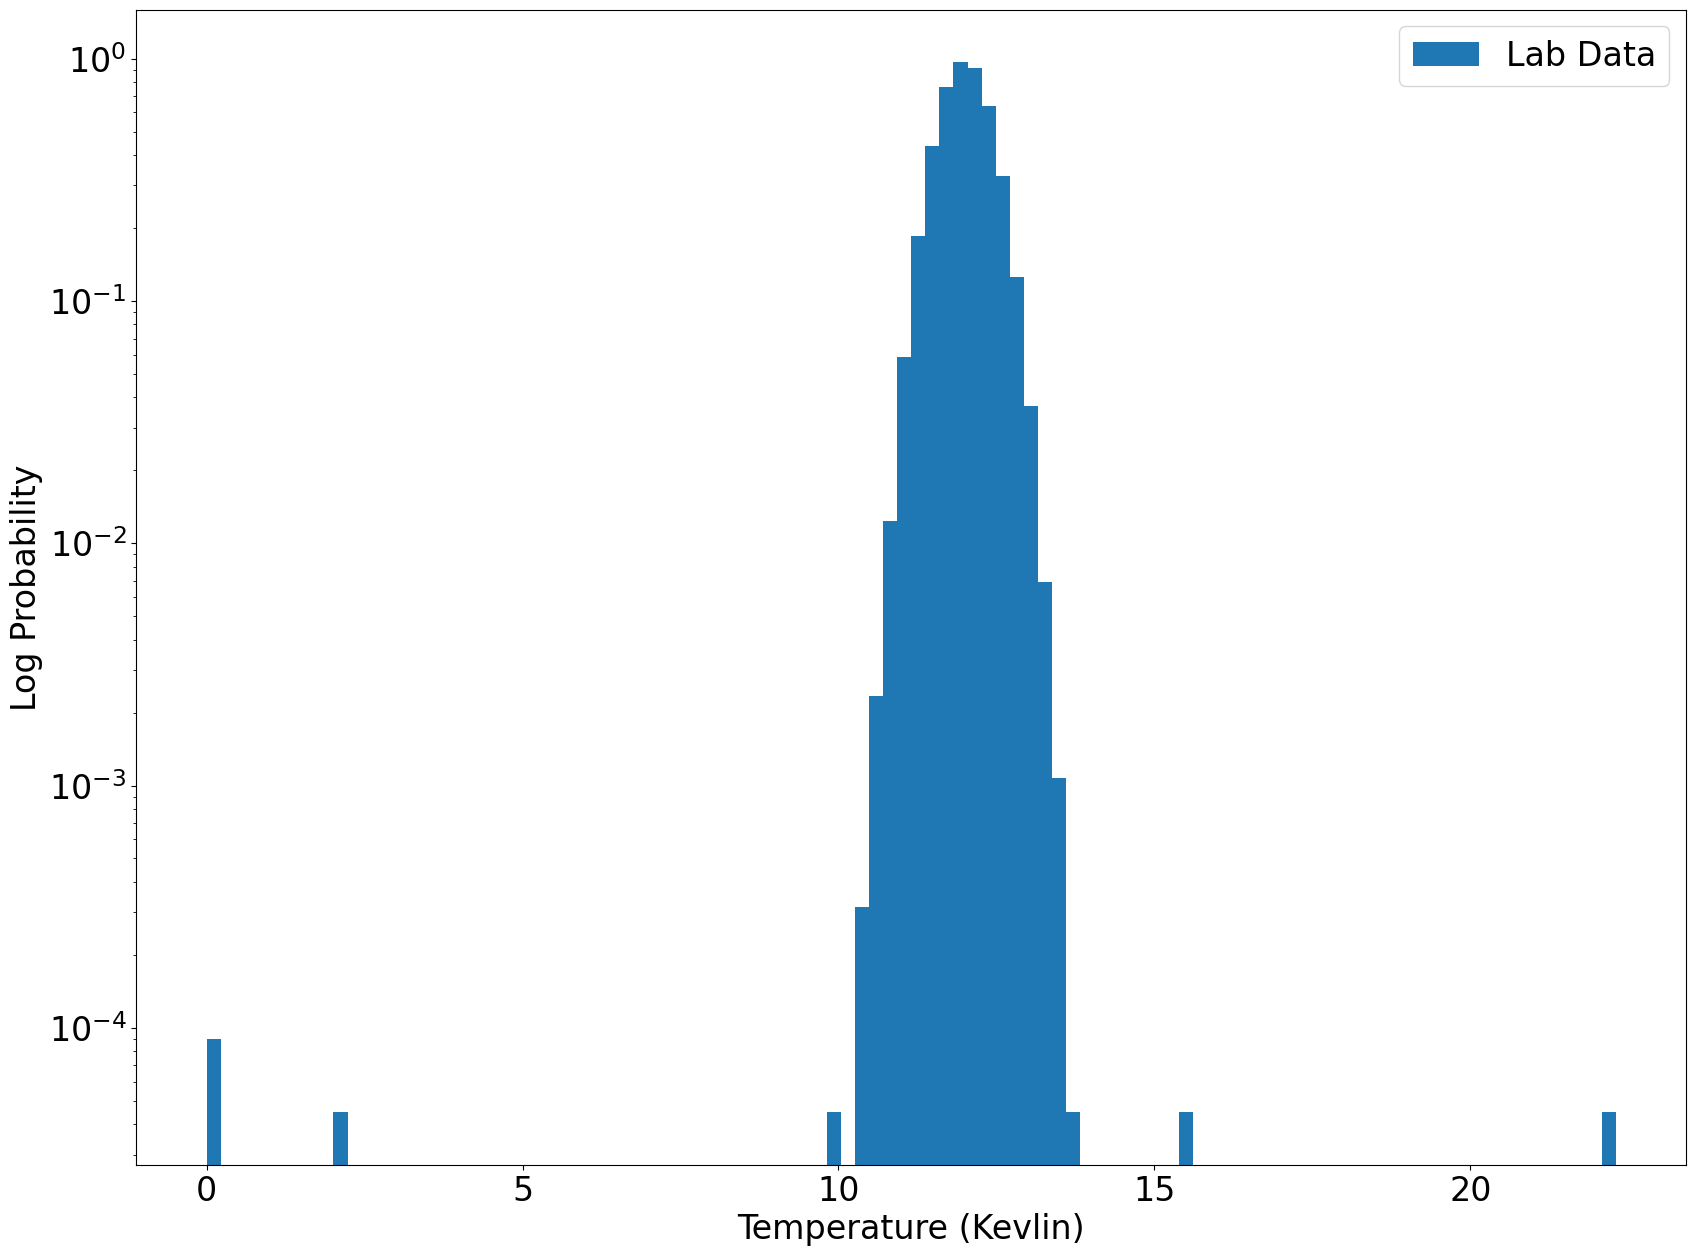

In [2]:
# distirbution information
mean_temp = 12
std_temp = 0.4

# generation of good points and bad points
true_data_N = 100000
outliers = [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7]
draw = np.append(stats.norm.rvs(loc=mean_temp, scale=std_temp, size=true_data_N), outliers)

# plotting
fig, ax = plt.subplots(1, 1)
ax.hist(draw, 100, density=True, label="Lab Data")
plt.tick_params(labelsize = 24)
plt.yscale('log')
plt.xlabel('Temperature (Kevlin)', fontsize=24)
plt.ylabel('Log Probability', fontsize=24)
plt.legend(fontsize=24)
plt.show()

### Part A

As previously stated, our goal is to identify and remove bad data.

Let's begin by first exploring our data when it is viewed on a non-logarithmic scale:

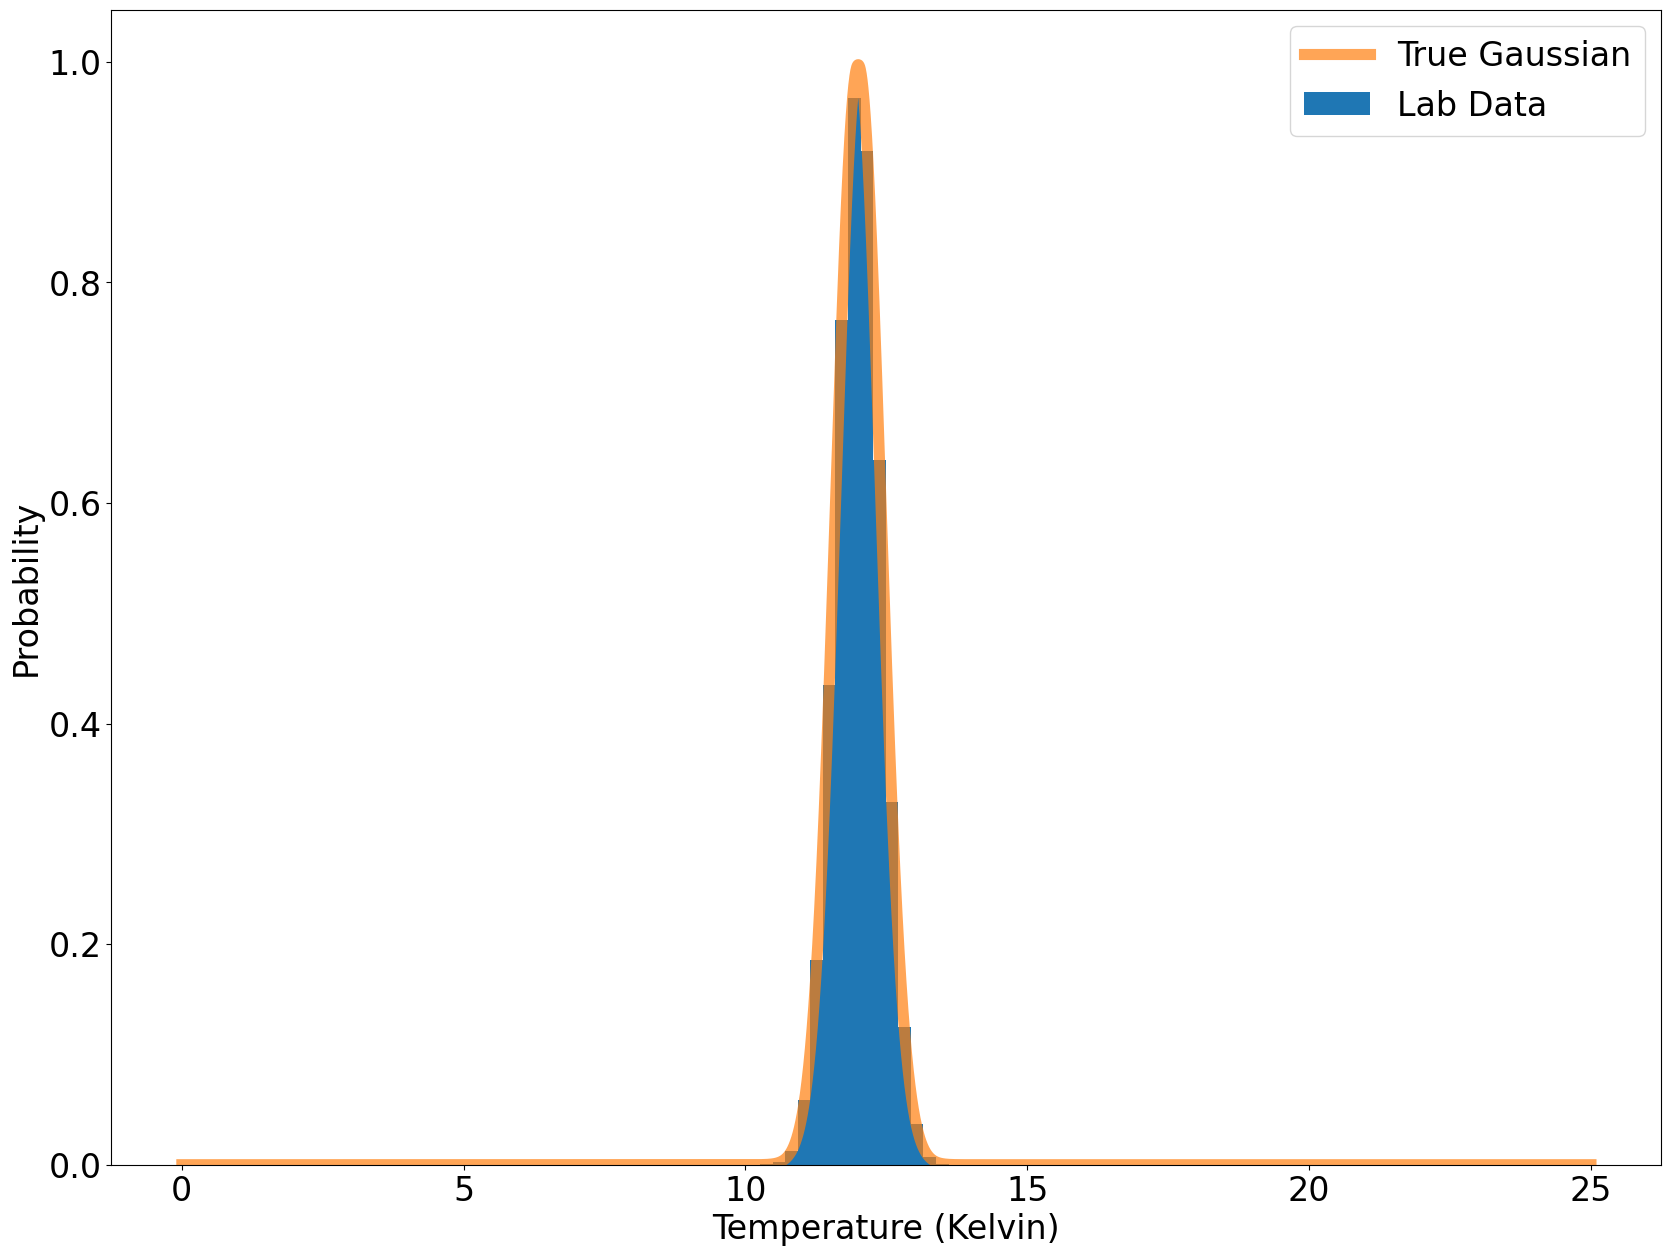

In [3]:
xs_true_gaus = np.linspace(0, 25, 5000)
probs_true_gaus = stats.norm.pdf(xs_true_gaus, loc=mean_temp, scale=std_temp)

fig, ax = plt.subplots(1, 1)
ax.hist(draw, 100, density=True, label="Lab Data")
ax.plot(xs_true_gaus, probs_true_gaus, linewidth=8, alpha=0.7, label="True Gaussian")
plt.tick_params(labelsize = 24)
plt.xlabel('Temperature (Kelvin)', fontsize=24)
plt.ylabel('Probability', fontsize=24)
plt.legend(fontsize=24)
plt.show()

From the above graph we see that when we view our distribution on a non-logarithmic plot the outliers are no longer visible because they are inconsequential compared to the rest of the data.  This reinforces the benefits of always looking at our plots on a semi-log scale.  Now lets go back to the semi-log plot and look at out true distribution and it's comparison to our data points:

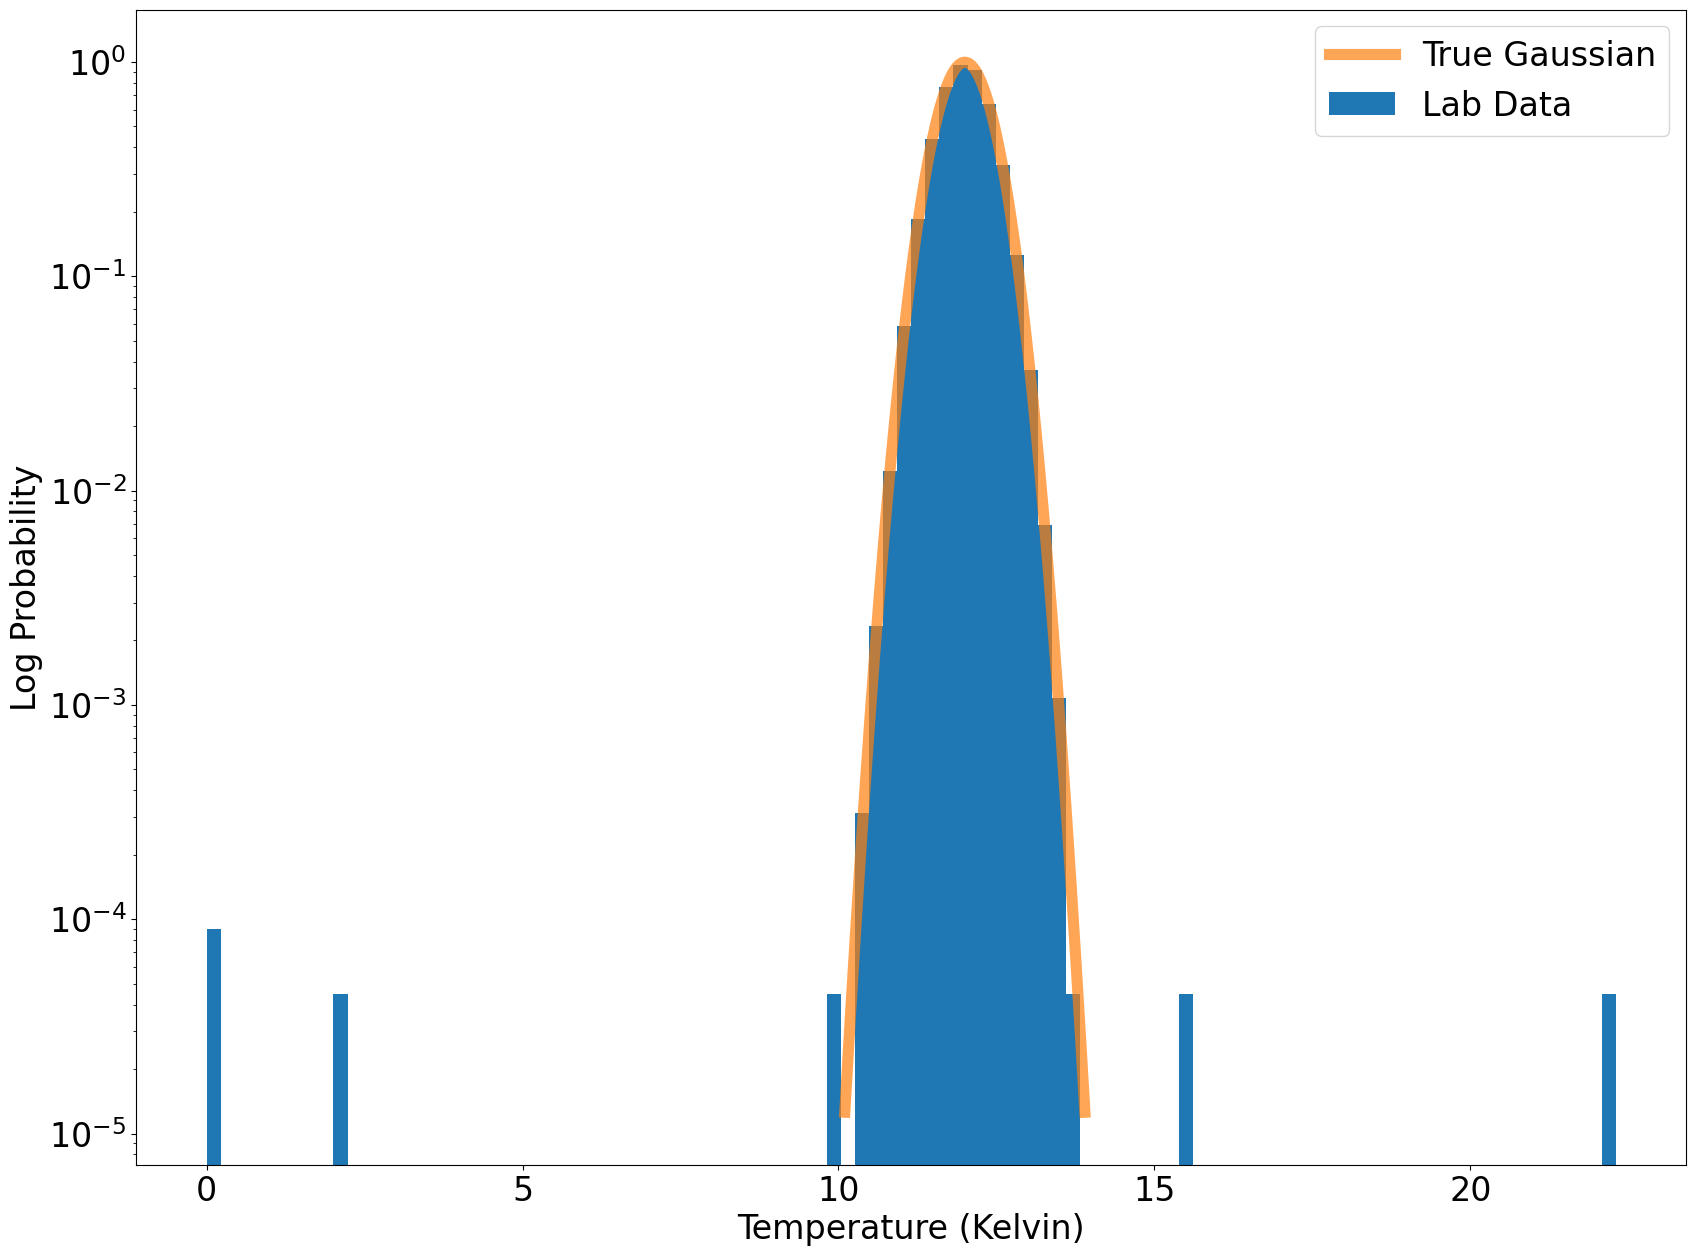

In [4]:
xs_true_gaus_truncated = np.linspace(10.1, 13.9, 1000)
probs_true_gaus_truncated = stats.norm.pdf(xs_true_gaus_truncated, loc=mean_temp, scale=std_temp)

fig, ax = plt.subplots(1, 1)
ax.hist(draw, 100, density=True, label="Lab Data")
ax.plot(xs_true_gaus_truncated, probs_true_gaus_truncated, linewidth=8, alpha=0.7, label="True Gaussian")
plt.tick_params(labelsize = 24)
plt.yscale('log')
plt.xlabel('Temperature (Kelvin)', fontsize=24)
plt.ylabel('Log Probability', fontsize=24)
plt.legend(fontsize=24)
plt.show()

From the above plot we see that the outliers are unrelated to the true Gaussian distribution entirely.  We also see from the plot on a non-logarithmic scale that the Gaussian rare events begin when the temperature is less than about 10 Kelvin or larger than around 14 Kelvin.  Thus we can view these outliers as rare events when we have this Gaussian distribution - the event for which our background would produce one of these outliers has a very small probability.

Now that we have explored our data, lets propose a statistical question for removing the outliers in our data:

> What outlier temperature must I have measured in order for the background Gaussian distribution ($\mu=12$, $\sigma=0.4$) to have a probability of $5\sigma$ or $-5\sigma$ to have produced that signal?

The reason I choose the above question is for the following reasons: first we know that we would like to remove the outliers so the goal of the question is to address how we can identify an outlier.  I have choose to identify an outlier as an event that has a probability equal to or smaller than the probability associated with a $5\sigma$ event or $-5\sigma$ event.  This bound will ensure that only rare events for the distribution are considered outliers and, we know, based on the shape of the distribution from the above graphs the outliers correspond to rare events.

Transforming this calculation into math, we will find all data points that have an $x$ value which is greater than or equal to $12 + T_{threshold}$ Kelvin or less than or equal to $12 - T_{threshold}$ Kelvin where $T_{threshold}$ is calculated using the following equation:

$$\int_5^\infty \text{pdf}_{normal}(x) dx = \int_{12 + T_{threshold}}^\infty \text{pdf}_{temperature \text{ } distribution}(x) dx$$

$$\int_5^\infty \frac{1}{\sqrt{2\pi}} e^{-x^2 / 2} dx = \int_{12 + T_{threshold}}^\infty \frac{1}{0.4 * \sqrt{2\pi}} e^{-(x-12)^2/(2*0.4^2)} dx$$

$$\int_5^\infty e^{-x^2 / 2} dx = \int_{12 + T_{threshold}}^\infty \frac{1}{0.4} e^{-(x-12)^2/(0.32)} dx$$

Let's now perform the reverse integral (specifically the inverse survival function) to determine the value of $T_{threshold}$:

In [5]:
# define the sigma value
sigma = 5

# determine the probability associated with this sigma
prob_sigma = stats.norm.sf(sigma, loc=0, scale=1)

# use the inverse survival function to determine the value that has the same associated probability
T_same_prob = stats.norm.isf(prob_sigma, loc=mean_temp, scale=std_temp)

# compute T_threshold
T_threshold = T_same_prob - mean_temp

print(f'The value of T_threshold is {T_threshold}')

The value of T_threshold is 2.0


Now we know that for a data point to be considered an outlier based on the requirements previously outlined, that data point must have a temperature equal to or less than 10 Kelvin or greater than or equal to 14 Kelvin.  Lets now calculate how many values fit this metric:

In [6]:
# print information we already know about the true outlier and true data counts
print(f'In total we have {len(draw)} temperatures we would like to identify.')
print(f'The number of true temperature data points is: {true_data_N}')
print(f'The number of true outliers is: {len(outliers)}')

# now calculate how many outliers are identified
def is_outlier(value):
    return value <= mean_temp - T_threshold or mean_temp + T_threshold <= value

N_identified_outliers = 0
for d in draw:
    if (is_outlier(d)):
        N_identified_outliers += 1
        
print(f'The number of identified outliers based on our metric is: {N_identified_outliers}')
print(f'The number of identified data points based on our metric is: {len(draw) - N_identified_outliers}')

In total we have 100008 temperatures we would like to identify.
The number of true temperature data points is: 100000
The number of true outliers is: 8
The number of identified outliers based on our metric is: 6
The number of identified data points based on our metric is: 100002


Based on the above results, lets construct a truth table that captures the accuracy of our previously defined performance metric to determine if data should be considered an outlier or not:

|          | **True T**     | **Bad T** |
|--------------|-----------|------------|
| Identified as Good T | 100000      | 2        |
| Identified as Bad T      | 0  | 6       |

### Part B

In the above table we see that all of our real temperature data points were identified as such however two of our false readings were identified as true readings.  We see that the proposed metric is does a fairly good job of separating the true and false readings.  The number of omissions of true data is directly related to the initial threshold parameter that we set.  In our proposed method, we set that threshold at $5\sigma$.  As this value is decreased, we will omit more and more of the true data but we will be more certain that we are not including any false readings.  The percentage of true temperature readings that would be omitted is a predictable value because our data is from a Gaussian.  We know that on a Gaussian, 68% of the readings, on average, will lie between $-1\sigma$ and $1\sigma$.  Thus we would omit, on average, 32% of our true temperature readings.

If instead we had set our value at $2\sigma$ we know that 95% of our readings, on average, will lie between $-2\sigma$ and $2\sigma$ thus we will omit 5% of the true temperature readings.  Similarly, if we set our value to $3\sigma$ we would omit 0.3% of our true temperature readings.  Even at this point of 3% we see that the probability of omitting a true reading is already fairly small so any value above $3\sigma$ should perform fairly well in correctly discarding the outliers while keeping the true temperature readings.

### Part C

Similar to the conversation in the previous part, we see that there are mistakes of commission (bad data being considered good) with our statistical threshold value of $5\sigma$ and, if we follow the same line of reasoning as in the previous part, we can conclude that the number of mistakes of commission is related to the statistical threshold.  As we decrease the value of our statistical threshold, the number of mistakes of commission will also decrease.  Additionally, these mistakes of commission are entirely avoidable, however it _can_ come with the trade off of throwing out true temperature readings as well.

## Problem 2

In this example we will be looking for asteroids. If we look at the alignment of stars on subsequent images, they don't perfectly align due to atmospheric and instrumental effects (even ignoring proper motion). The resulting distribution is two dimensional, and for this lab let's assume it is a 2D Gaussian with 1 arcsecond RMS. Or said another way, if we histogram how far all the (stationary) stars appear to have moved then we get something like this:

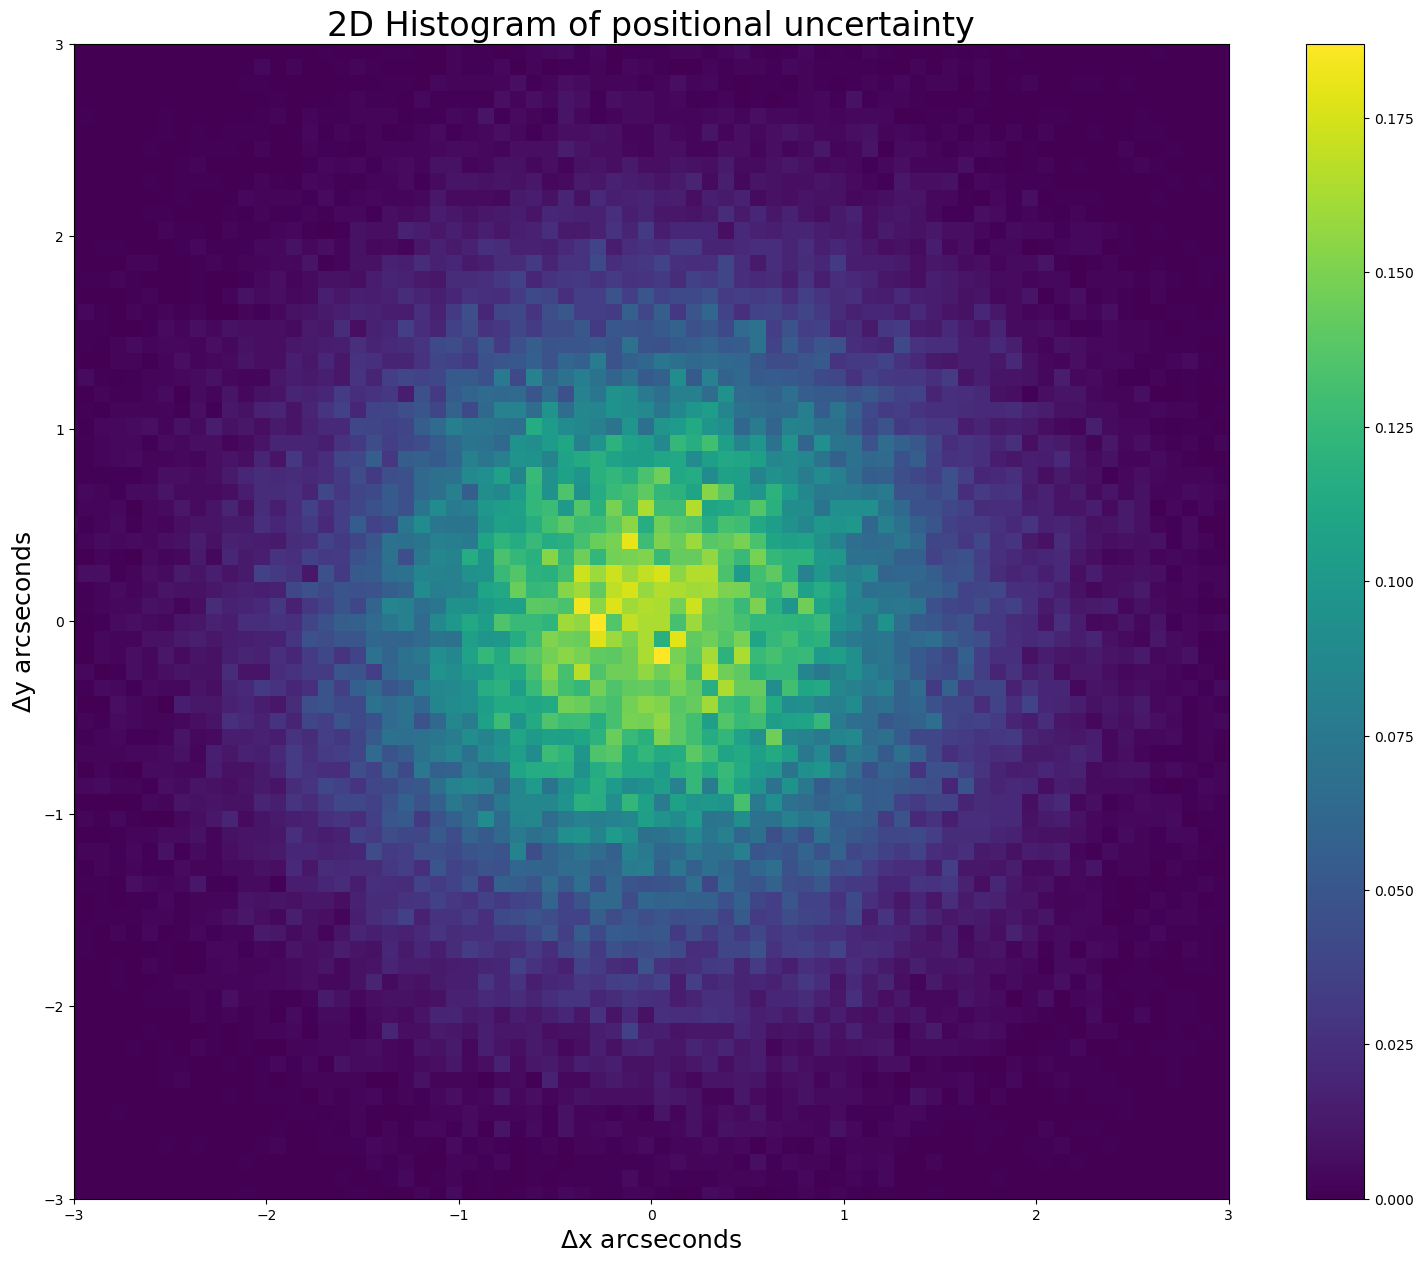

In [7]:
a = np.vstack((stats.norm.rvs( scale = 1, size = 100000), stats.norm.rvs( scale = 1, size = 100000)))
a.shape
fig, ax = plt.subplots(1, 1)
h = ax.hist2d(a[0,:],a[1,:],bins=100, density=True);
ax.set_aspect('equal', 'box')
plt.xlim([-3 , 3])
plt.ylim([-3 , 3])
plt.title("2D Histogram of positional uncertainty", fontsize = 24)
plt.ylabel("$\Delta$y arcseconds", fontsize = 18)
plt.xlabel("$\Delta$x arcseconds", fontsize = 18)
plt.colorbar(h[3], ax=ax)

### Part A

**If we have a potential asteroid, it will have some true movement between the images. We would like a '5 sigma' detection of movement. What is that distance in arcseconds?**

If we have a moving asteroid we would expect said asteroid to be a rare event on the above plot as the above plot shows that the background stars do not move very much - although they do move.  We would like to determine what distance in arcseconds corresponds to a 5-sigma detection of movement.  Recall that the distance to a point on the above plot will be defined as $\sqrt{X^2 + Y^2}$ where $X$ is the Gaussian random variable for $\delta x$ arc seconds and $Y$ is the Gaussian random variable for $\delta y$ arcseconds.

Provided this information we need to determine what out background distribution for the distance is.  Looking at the wikipedia page for the Rayleigh distribution we find that when computing the length of a vector composed of random variables (here we have $V=X\widehat{i} + Y\widehat{j}$) we end up with a a Rayleigh distribution if the two random variables $X$ and $Y$ are Gaussian distributed with the same mean and standard deviation - which is the case here.  The final Rayleigh distribution will have the same mean and standard deviation of the two Gaussian random variables.  Lets visualize our resulting probability distribution function, $\text{pdf}_{movement}(x)$:

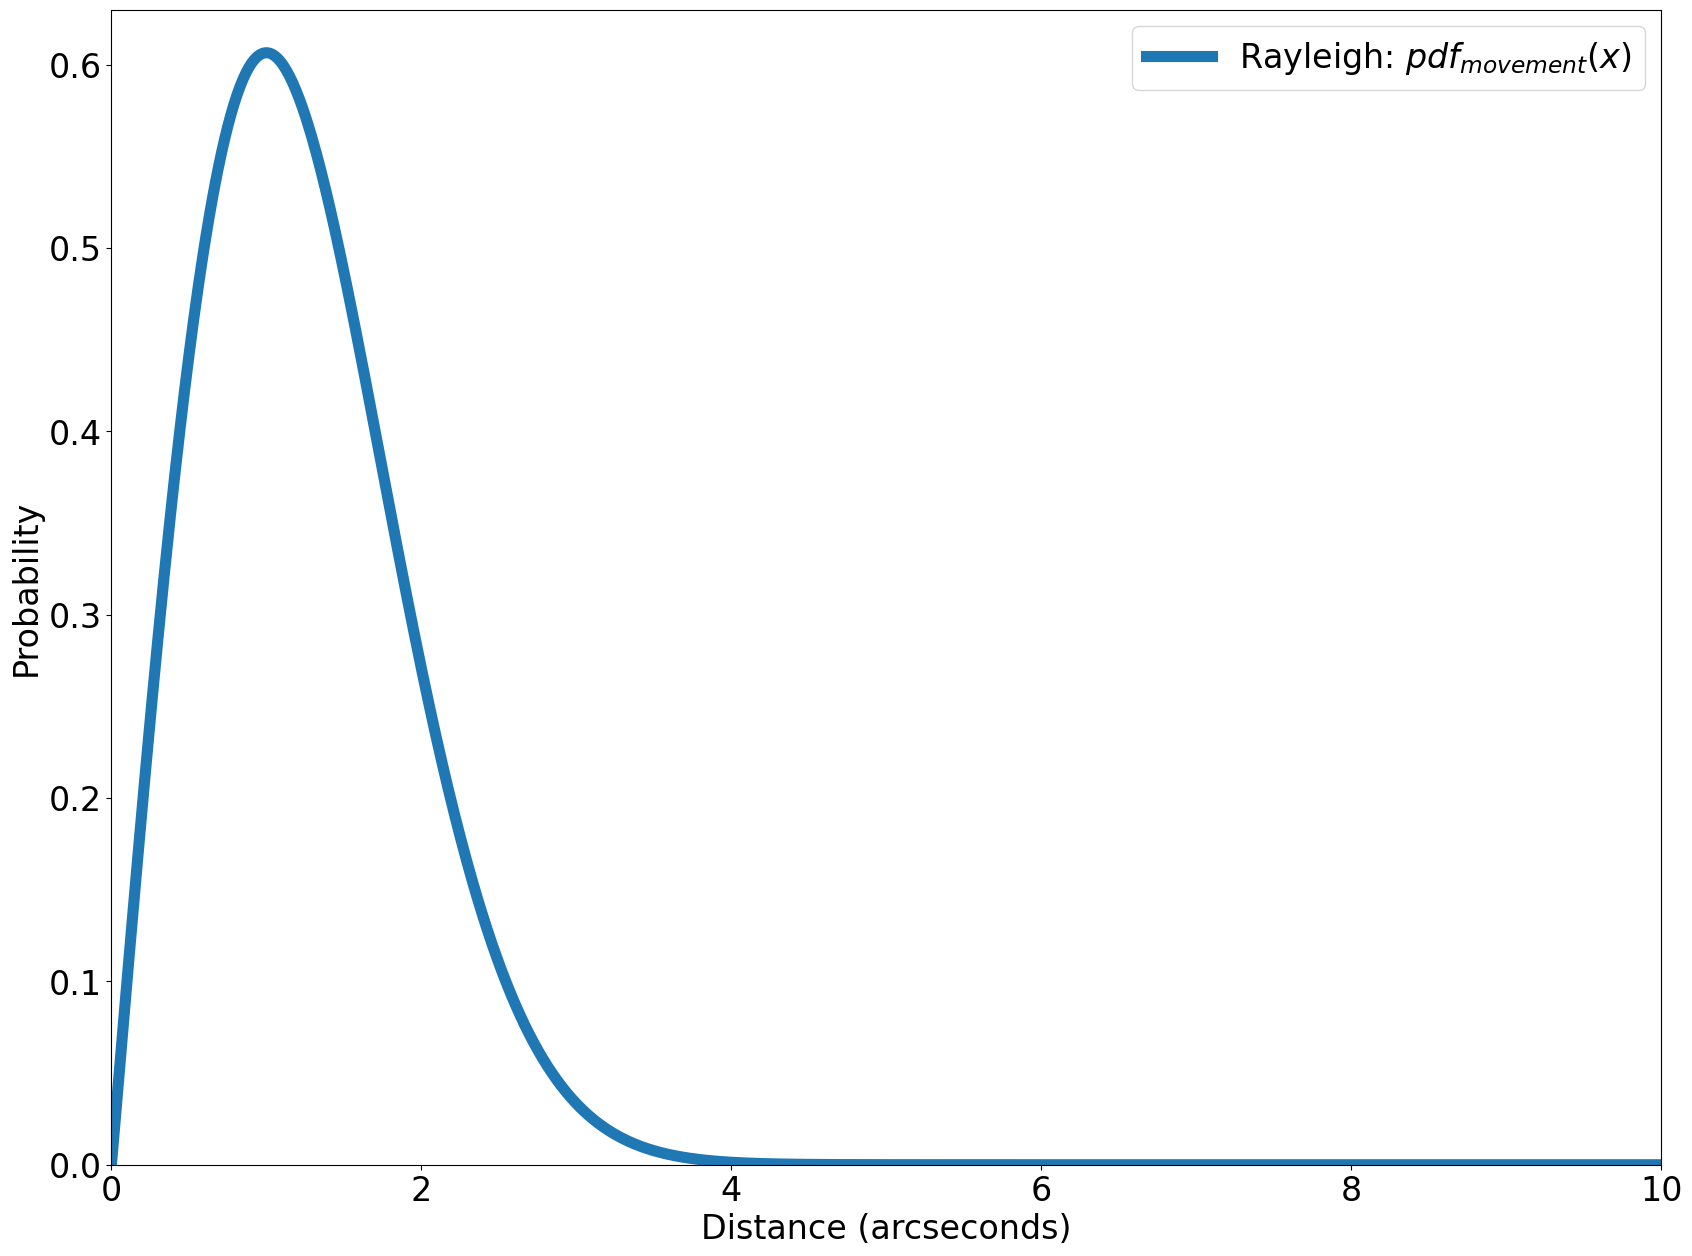

In [34]:
# variable setup
rayleigh_mean = 0
rayleigh_std = 1
rayleigh_xs = np.linspace(0, 10, 1000)
rayleigh_probs = stats.rayleigh.pdf(rayleigh_xs, loc=rayleigh_mean, scale=rayleigh_std)

# plot
plt.plot(rayleigh_xs, rayleigh_probs, linewidth=8, label="Rayleigh: $pdf_{movement}(x)$")
plt.tick_params(labelsize = 24)
plt.xlabel('Distance (arcseconds)', fontsize=24)
plt.ylabel('Probability', fontsize=24)
plt.xlim(0, 10)
plt.ylim(0, 0.63)
plt.legend(fontsize=24)
plt.show()

From this we can formulate our statistical question:

> What distance in arcseconds would I have to measure, for the asteroid movement, in order for me to have a 5-sigma probability that my background - a Rayleigh distribution (parameters mean=0, std=1) - produced that distance measurement?

Thus if we would like to determine the arcsecond distance, $D$, associated with a 5-sigma event we will begin by determining the probability of a 5-sigma event then we will use that probability to perform the reverse integral on the the proper Rayleigh distribution to determine the required arcsecond distance for a 5-sigma detection of movement.  Mathematically, we can can write this in the following way:

$$\int_5^\infty \text{pdf}_{normal}(x) dx = \int_{D}^\infty \text{pdf}_{movement}(x) dx$$

$$\int_5^\infty \frac{1}{\sqrt{2\pi}} e^{-x^2 / 2} dx = \int_{D}^\infty x e^{-x^2 / 2} dx$$

Now lets determine the distance, in arcseconds, required for a 5-sigma detection of motion.

In [9]:
# define the sigma value
sigma = 5

# determine the probability associated with this sigma
prob_sigma = stats.norm.sf(sigma, loc=0, scale=1)

# use the inverse survival function to determine the value that has the same associated probability
D_same_prob = stats.rayleigh.isf(prob_sigma, loc=0, scale=1)

print(f'The distance required is: {D_same_prob:.3f} arcseconds')

The distance required is: 5.489 arcseconds


From the above result we find that a distance of $5.489$ arcseconds is required for the background distribution to have a probability of $5\sigma$ to produce that same distance.  This tells us that if we observe a movement larger than this value then we can confidently classify that movement to be produced by an astroid rather than produced by the background distribution.  Note that as this is a _distance_ a circle will be drawn out on the **2D Histogram of positional uncertainty** plot with a radius of $5.489$ arcseconds.  Any distance measurement, in arcseconds, that lies outside of this circle can be confidently classified as not being produced by the background but rather as a true signal - or true asteroid.

## Problem 3

As we have previously discussed, a key background for gamma-ray telescopes is the cosmic-ray background.  Cosmic rays are charged particles—usually protons or electrons but can include atomic nuclei such alpha particles (helium) or iron.  Because of their charge cosmic rays spiral in the magnetic field of the galaxy.  From the perspective of the Earth they appear to be coming uniformly from all directions like a high energy gas, and the direction the cosmic ray is traveling when it reaches the Earth tells us nothing about where it came from because we don't know what tortured path it has taken through the galaxy to reach us.  However, at trillion electron volt energies and above, the spiral loops are fairly big and the sun and the moon will block cosmic rays.  This means the sun and the moon appear as holes in the cosmic ray sky (cosmic rays from that direction are absorbed).

Assume in a moon sized patch on the sky we normally have a cosmic ray rate of 1 cosmic ray per minute (arrivals are random in time). If we can observe where the moon is for 8 hours per night (not too close to the horizon) and we observe for 15 days and see 6800 cosmic rays, what is the significance of our moon shadow detection?

Here the distribution for 1 minute will be a Poisson distribution with parameter 1 cosmic-ray / minute.  We can draw this conclusion because we know that we must measure an integer amount of cosmic rays which restricts us to discrete distributions.  Further, the Poisson distribution is widely applicable in particle physics and it is known that the cosmic background is Poisson distributed.  Lets visualize this distribution:

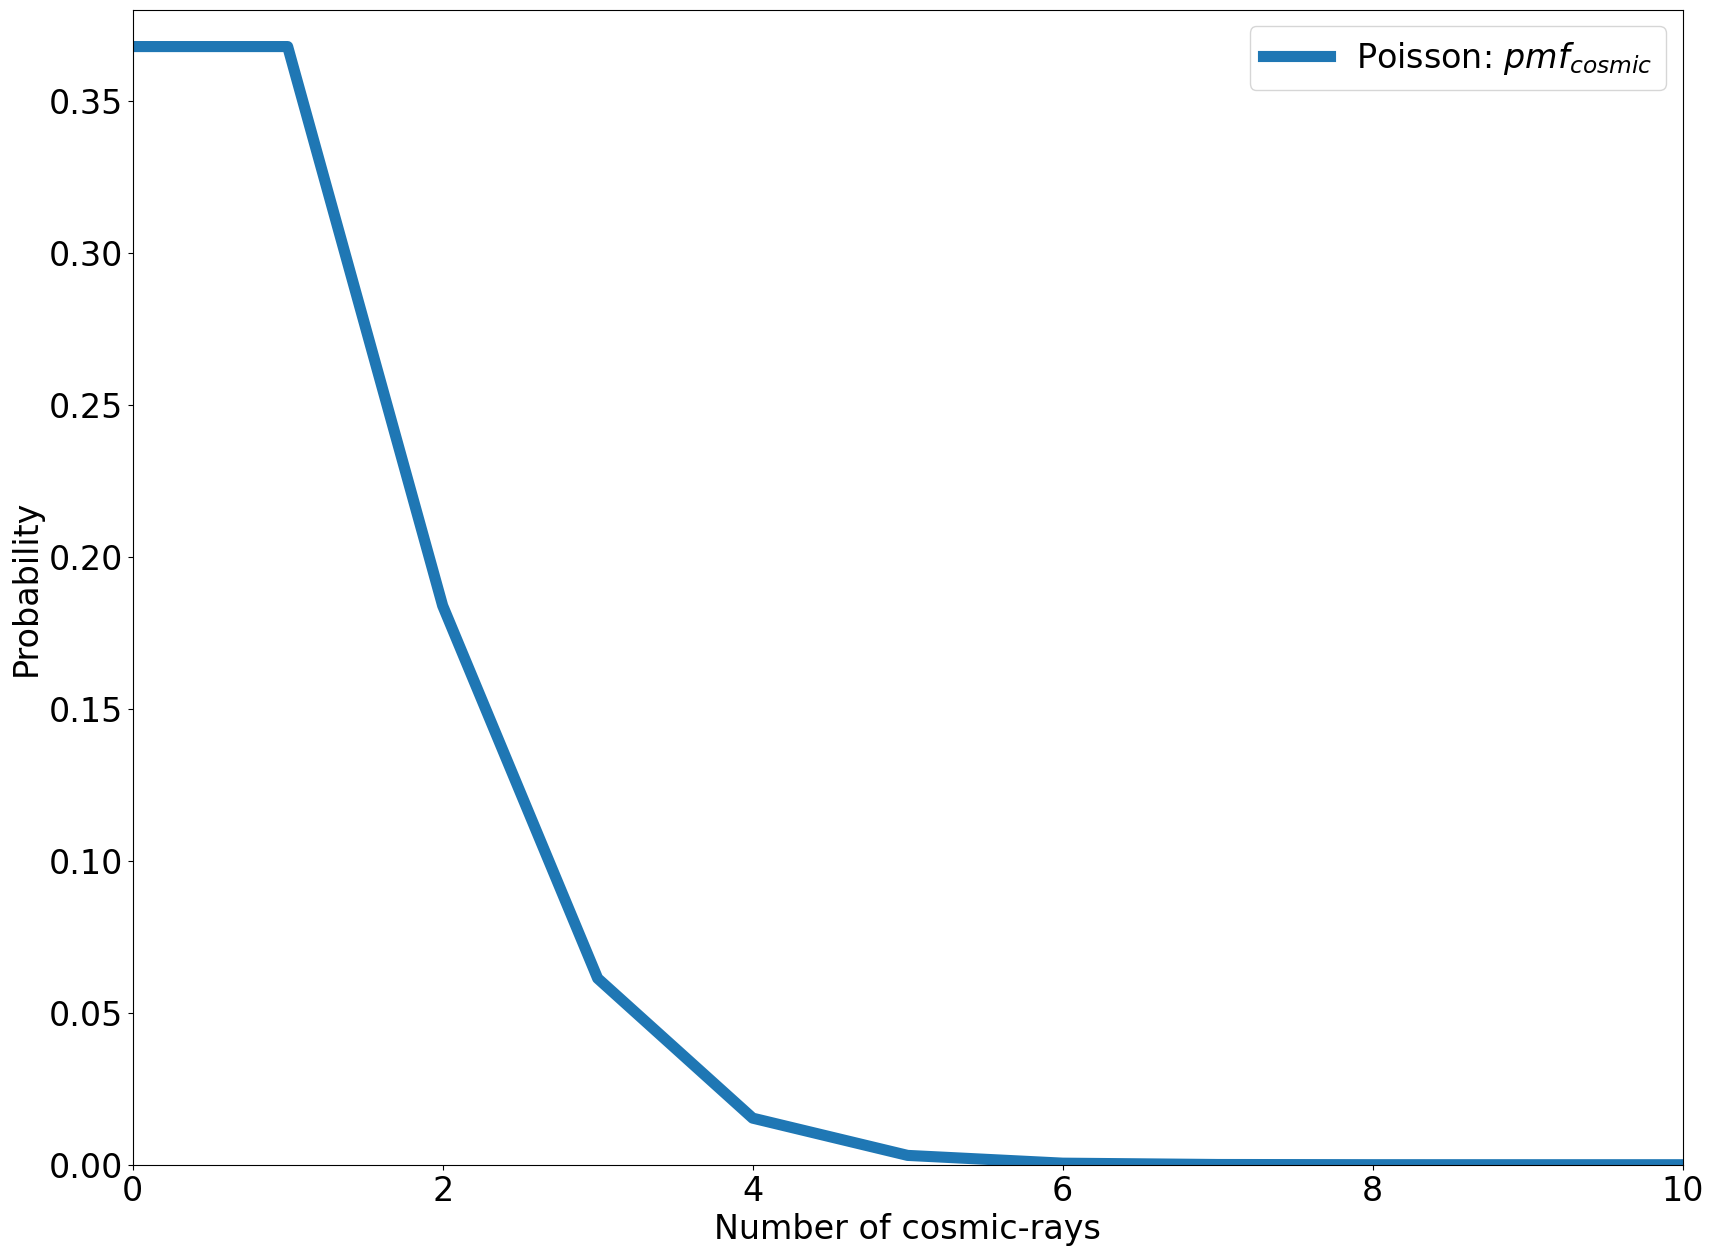

In [27]:
# variables
lambda_cosmic_ray = 1 # cosmic ray / minute
xs_cosmic_ray = np.linspace(0, 10, 11)
ys_cosmic_ray = stats.poisson.pmf(xs_cosmic_ray, lambda_cosmic_ray)

# plot
plt.plot(xs_cosmic_ray, ys_cosmic_ray, linewidth=8, label="Poisson: $pmf_{cosmic}$")
plt.tick_params(labelsize = 24)
plt.xlabel('Number of cosmic-rays', fontsize=24)
plt.ylabel('Probability', fontsize=24)
plt.xlim(0, 10)
plt.ylim(0, 0.38)
plt.legend(fontsize=24)
plt.show()

Now recall that we are looking at the moon for 8 hours every night for 15 days.  This is a total time of $(15 days)*(8 hours/day)*(60 min/hour)=7200$ minutes.  To get the overall distribution then we would then sum 7200 Poisson distributions by convolving the Poisson distribution with itself 7200 times.  However rather than performing the convolution, it is known that the sum of $n$ Poisson random variables is Poisson distributed with a parameter $\lambda = \sum_{i=1}^n \lambda_i$ where $\lambda_i$ is the parameter of the $i$th Poisson random variable.  Thus our overall distribution is as follows:

$$\text{pdf}_{cosmic}(k) = \frac{7200^k e^{-7200}}{k!}$$

Lets graph our overall distribution:

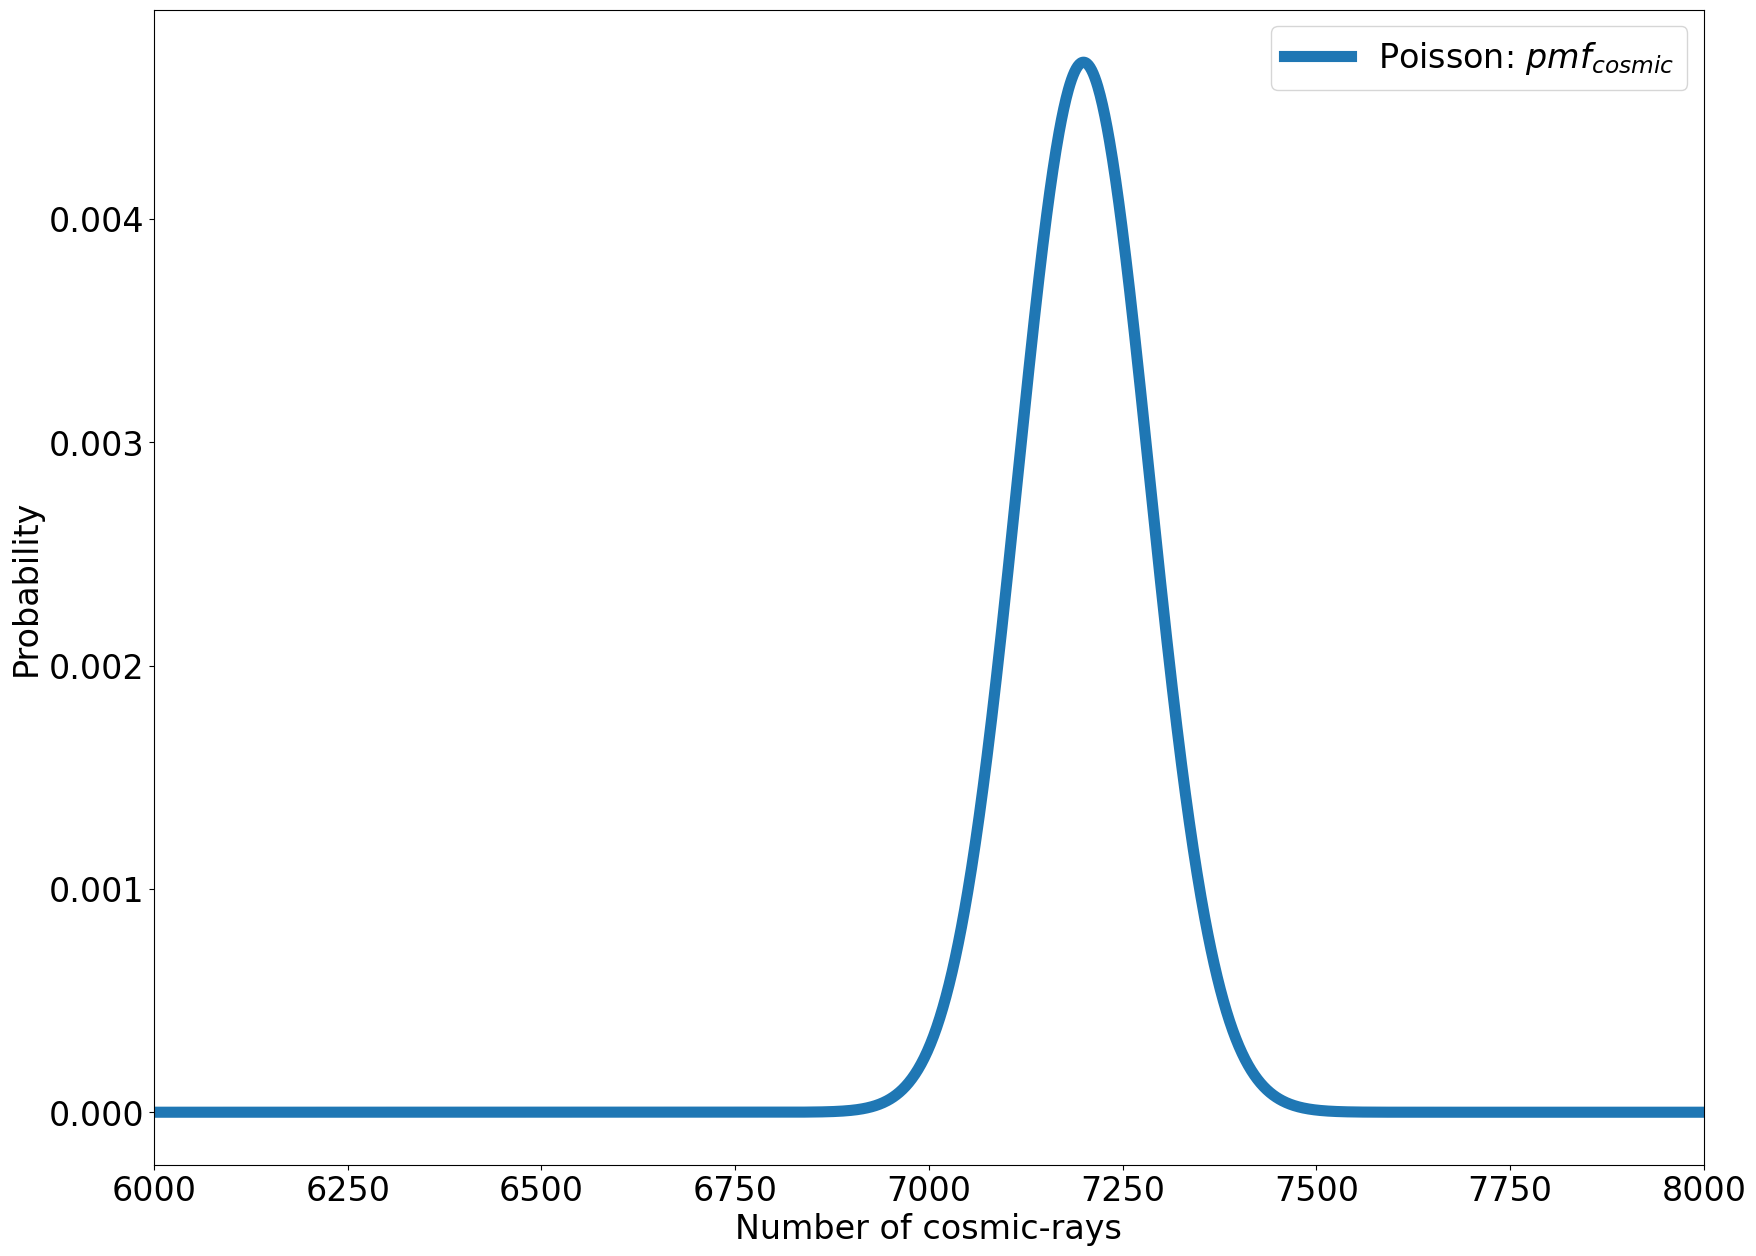

In [28]:
# variables
lambda_cosmic_ray_sum = 7200 # cosmic ray / minute
xs_cosmic_ray_sum = np.linspace(0, 10000, 10001)
ys_cosmic_ray_sum = stats.poisson.pmf(xs_cosmic_ray_sum, lambda_cosmic_ray_sum)

# plot
plt.plot(xs_cosmic_ray_sum, ys_cosmic_ray_sum, linewidth=8, label="Poisson: $pmf_{cosmic}$")
plt.tick_params(labelsize = 24)
plt.xlabel('Number of cosmic-rays', fontsize=24)
plt.ylabel('Probability', fontsize=24)
plt.xlim(6000, 8000)
plt.legend(fontsize=24)
plt.show()

Now that we have our distribution, lets ask the statistical that we would like to answer:

> What is the probability that my background, a Poisson distribution (parameter=7200), produced a signal as signal-like or more than my signal of 6800 cosmic rays over the time period of 7200 minutes?  Where being more 'signal-like' is defined as having a smaller number of cosmic-rays over the time period of 7200 minutes (i.e., a lack of cosmic-rays is more signal-like).

Mathematically, we can write this question in the following way where we are looking for our statistical-significance $N\sigma$:

$$\sum_{i=0}^{6800} \text{pmf}_{cosmic}(i,7200) = \int_{N}^{\infty} \text{pdf}_{normal}(x) dx$$

$$\sum_{i=0}^{6800} \frac{7200^i e^{-7200}}{i!} = \int_{N}^{\infty} \frac{1}{\sqrt{2\pi}} e^{-x^2 / 2} dx$$

Lets now calculate our statistical significance:

In [33]:
# define the signal
signal = 6800 # cosmic-rays
background_parameter = 7200

# determine the probability associated with this sigma
prob_signal = stats.poisson.cdf(signal, background_parameter)

# use the inverse survival function to determine the value that has the same associated probability
signal_sigma = stats.norm.isf(prob_signal, loc=0, scale=1)

print(f'The statistical significance of the moon shadow detection is {signal_sigma:.3f} sigma')

The statistical significance of the moon shadow detection is 4.751 sigma


Now we can conclude that the statistical significance of the moon shadow detection of 6800 cosmic-rays being detected over the time interval of 7200 minutes is $4.751\sigma$.